<a href="https://colab.research.google.com/github/Chiraz32/Deep-Learning-Labs/blob/main/tp4_dL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade tensorflow keras

In [ ]:
!pip install keras

In [ ]:
! pip install tensorflow

In [ ]:
#@title List of imports
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
# from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten ,LSTM ,Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import zipfile
import os
import re


In [ ]:
#@title Extracting and saving datasets
# Specify the paths for your ZIP files and the extraction directories
zip_glove_path = '/content/drive/MyDrive/tp4_datasets/glove.6B.100d.txt.zip'
glove_extract_path = '/tmp/glove'

zip_imdb_path = '/content/drive/MyDrive/tp4_datasets/IMDB Dataset.csv.zip'
imdb_extract_path = '/tmp/imdb'

# Extract the GloVe data
try:
    with zipfile.ZipFile(zip_glove_path, 'r') as zip_glove_data:
        zip_glove_data.extractall(glove_extract_path)
    print("GloVe data extracted successfully.")
except Exception as e:
    print("Error extracting GloVe data:", e)

# Extract the IMDB dataset
try:
    with zipfile.ZipFile(zip_imdb_path, 'r') as zip_imdb_data:
        zip_imdb_data.extractall(imdb_extract_path)
    print("IMDB dataset extracted successfully.")
except Exception as e:
    print("Error extracting IMDB dataset:", e)


GloVe data extracted successfully.
IMDB dataset extracted successfully.


In [ ]:
# Chemin vers le fichier CSV IMDB Dataset.csv
imdb_csv_path = '/tmp/imdb/IMDB Dataset.csv'

# Importer le jeu de données en tant que DataFrame
df_imdb = pd.read_csv(imdb_csv_path)

# Afficher les dimensions du DataFrame (nombre de lignes, nombre de colonnes)
dimensions = df_imdb.shape
print("Dimensions du dataset IMDB :", dimensions)

# Vérifier s'il y a des valeurs NULL dans le dataset
valeurs_null = df_imdb.isnull().sum().sum()
if valeurs_null == 0:
    print("Le dataset ne contient pas de valeurs NULL.")
else:
    print("Le dataset contient des valeurs NULL.")

# Afficher les 5 premières lignes du dataset
print("\nLes 5 premières lignes du dataset IMDB :")
print(df_imdb.head())


Dimensions du dataset IMDB : (50000, 2)
Le dataset ne contient pas de valeurs NULL.

Les 5 premières lignes du dataset IMDB :
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


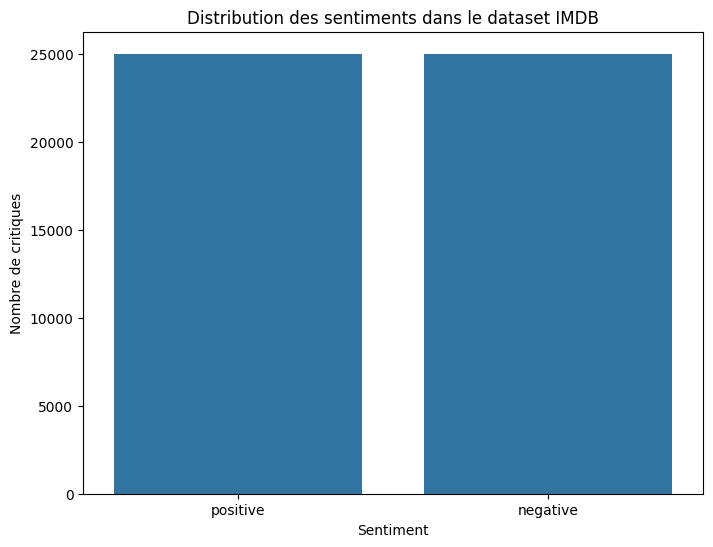

In [ ]:
#@title Test dataset balance
import seaborn as sns
import matplotlib.pyplot as plt

# Utiliser countplot pour visualiser l'équilibre des classes
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_imdb)
plt.title('Distribution des sentiments dans le dataset IMDB')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de critiques')
plt.show()


We have a balanced dataset, 25000 for the positive reviews and 25000 for the negative reviews

In [ ]:
# Afficher le 4ème review du dataset IMDB
print("4ème review du dataset IMDB :")
print(df_imdb['review'].iloc[3])
print(df_imdb['sentiment'].iloc[3])


4ème review du dataset IMDB :
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.
negative


In [ ]:
#@title Preprocess data
# Description: this code
  # Removes HTML tags using regex.
  # Deletes punctuation and numbers.
  # Eliminates single alphabetic characters.
  # Replaces multiple spaces with a single space.


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence



1. Removes HTML tags using regex.
2. Deletes punctuation and numbers.
3. Eliminates single alphabetic characters.
4. Replaces multiple spaces with a single space.
5. remove html tags /balises

In [ ]:
X=[]
sentences = list(df_imdb['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

y = df_imdb['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Tokenizer creation

1. Create a tokenizer that will convert words to numbers, keeping only the top 5000 most frequent words.
2. Train the tokenizer on the training data (X_train) to build a vocabulary and assign numbers to words.
3. Convert the training data (X_train) from words to sequences of numbers using the trained tokenizer.
4. Convert the test data (X_test) from words to sequences of numbers using the same tokenizer as the training data.

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

1. Calculate the vocabulary size by adding 1 to the number of unique words in the tokenizer's word index, accounting for the reserved index 0.
2. Set the maximum sequence length (`maxlen`) to 100.
3. Pad sequences in the training data (`X_train`) to have a uniform length of 100 by adding zeros at the end (`post` padding).
4. Pad sequences in the test data (`X_test`) using the same maximum length and padding method as the training data.

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#  Word embedding with glove
1. Create an empty dictionary (`embeddings_dictionary`) to store word embeddings.
2. Open the GloVe word embeddings file (`glove.6B.100d.txt`) located at "/tmp/glove/" in UTF-8 encoding.
3. Iterate through each line in the GloVe file.
4. Split each line into a list of records.
5. Extract the word from the first record in the line.
6. Convert the vector dimensions (remaining records after the word) to a numpy array of float32 data type using `asarray`.
7. Add the word and its corresponding vector dimensions to the `embeddings_dictionary`.
8. Close the GloVe file after processing all lines.

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open("/tmp/glove/glove.6B.100d.txt", encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:],dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

1. Create an empty matrix (`embedding_matrix`) of dimensions (vocab_size, 100) filled with zeros.
2. Iterate through each word and its corresponding index in the tokenizer's word index.
3. Check if the word exists in the `embeddings_dictionary`.
4. If the word is found in the dictionary, retrieve its embedding vector.
5. Update the corresponding row in the `embedding_matrix` with the embedding vector if it exists for that word.

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
   embedding_vector = embeddings_dictionary.get(word)
   if embedding_vector is not None:
       embedding_matrix[index] = embedding_vector

The embedding matrix will have:
- Non-zero rows for words found in GloVe, containing their pre-trained embedding vectors.
- Zero-initialized rows for words not in GloVe, relying on the model to learn their representations during training.
- A special handling for reserved tokens like padding (e.g., index 0), which might also be zero-initialized or set to a specific value.

### 1- Simple neural network

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.optimizers import Adam

# Créer le modèle séquentiel
model_1= Sequential()
model_1.add(keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen , trainable=False))
# Ajouter la couche Flatten
model_1.add(Flatten())
# Ajouter la couche Dense
model_1.add(Dense(units=1, activation='sigmoid'))
# Compiler le modèle
model_1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# Fit Parameters
epochs = 6
batch_size = 128

# Train the model
history_1 = model_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Afficher la structure du modèle
model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6221 - loss: 0.6494 - val_accuracy: 0.7280 - val_loss: 0.5408
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7648 - loss: 0.4913 - val_accuracy: 0.7436 - val_loss: 0.5194
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7938 - loss: 0.4496 - val_accuracy: 0.7284 - val_loss: 0.5477
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8028 - loss: 0.4292 - val_accuracy: 0.7440 - val_loss: 0.5261
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8172 - loss: 0.4077 - val_accuracy: 0.7421 - val_loss: 0.5289
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8289 - loss: 0.3895 - val_accuracy: 0.7450 - val_loss: 0.5313


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (128, 10000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (128, 1)                    │          10,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,284,705 (35.42 MB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 20,004 (78.14 KB)

In [ ]:
score_1 = model_1.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score_1[0])
print("Test Accuracy:", score_1[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7350 - loss: 0.5394
Test Score: 0.5353384017944336
Test Accuracy: 0.7396000027656555


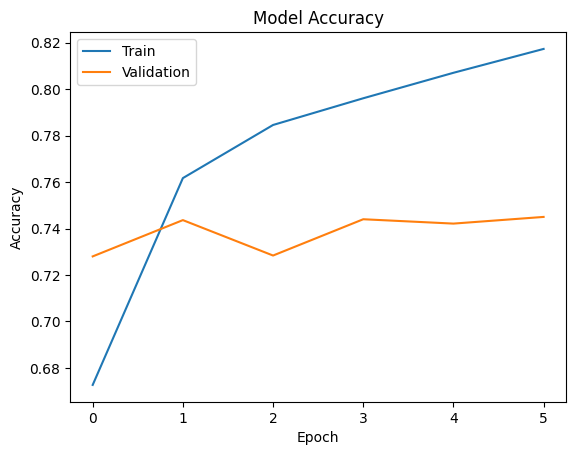

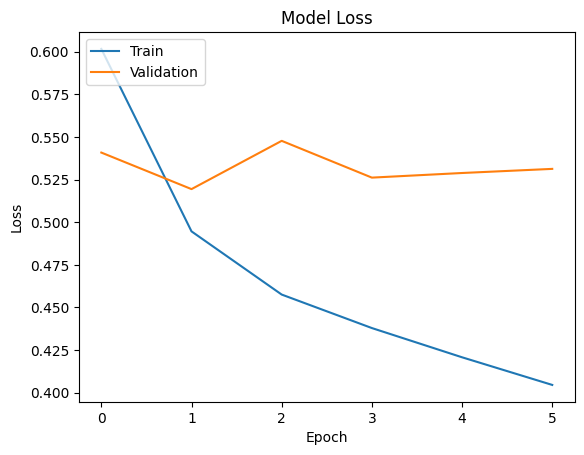

In [ ]:
import matplotlib.pyplot as plt


# Afficher l'accuracy
plt.plot(history_1.history['accuracy'])  # Utiliser 'accuracy' au lieu de 'acc'
plt.plot(history_1.history['val_accuracy'])  # Utiliser 'val_accuracy' au lieu de 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Afficher la loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


The accuracy on the training set is around 82% while 74% on the validation set =>the model is overfitting the data.

###2- CNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam

# Créer le modèle séquentiel
model_2 = Sequential()

model_2.add(Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen , trainable=False))

# Ajouter la couche Conv1D
filters = 128
kernel_size = 5
model_2.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))

# Ajouter la couche MaxPooling1D
model_2.add(MaxPooling1D())

model_2.add(Flatten())

# Ajouter la couche Dense
model_2.add(Dense(units=1, activation='sigmoid'))

# Compiler le modèle
model_2.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model_2.fit(X_train, y_train, epochs=6, batch_size=128, validation_split=0.2, verbose=1)

# Afficher la structure du modèle
model_2.summary()

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6073 - loss: 0.6669 - val_accuracy: 0.7575 - val_loss: 0.4996
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7892 - loss: 0.4489 - val_accuracy: 0.8024 - val_loss: 0.4304
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8259 - loss: 0.3845 - val_accuracy: 0.8161 - val_loss: 0.4026
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8622 - loss: 0.3233 - val_accuracy: 0.8206 - val_loss: 0.4037
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8954 - loss: 0.2685 - val_accuracy: 0.7891 - val_loss: 0.4629
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9281 - loss: 0.2100 - val_accuracy: 0.8066 - val_loss: 0.4460


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (128, 96, 128)              │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (128, 48, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (128, 6144)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (128, 1)                    │           6,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,465,521 (36.11 MB)

 Trainable params: 70,273 (274.50 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 140,548 (549.02 KB)

In [ ]:
score_2 = model_2.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score_2[0])
print("Test Accuracy:", score_2[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8045 - loss: 0.4522
Test Score: 0.44581934809684753
Test Accuracy: 0.8079000115394592


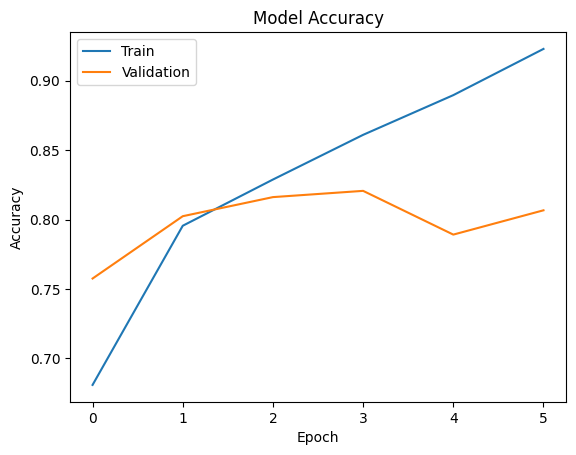

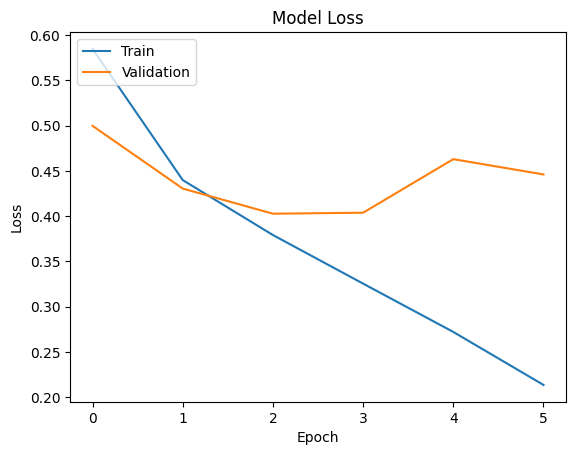

In [ ]:
import matplotlib.pyplot as plt


# Afficher l'accuracy
plt.plot(history.history['accuracy'])  # Utiliser 'accuracy' au lieu de 'acc'
plt.plot(history.history['val_accuracy'])  # Utiliser 'val_accuracy' au lieu de 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Afficher la loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


The accuracy on the training set is around 99% while on the validation set is around 85%
=>the model is overfitting the data. However , using the CNN the model is performing well on the trainset

### 3- LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Créer le modèle séquentiel
model_3 = Sequential()
model_3.add(Embedding(vocab_size,100, weights=[embedding_matrix],input_length=maxlen , trainable=False))

# Ajouter la couche LSTM
units = 128
model_3.add(LSTM(units=units))

# Ajouter la couche Dense
model_3.add(Dense(units=1, activation='sigmoid'))

# Compiler le modèle
model_3.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history_3 = model_3.fit(X_train, y_train, epochs=6, batch_size=128, validation_split=0.2, verbose=1)

# Afficher la structure du modèle
model_3.summary()

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6587 - loss: 0.6042 - val_accuracy: 0.7830 - val_loss: 0.4629
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7838 - loss: 0.4600 - val_accuracy: 0.8084 - val_loss: 0.4108
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8117 - loss: 0.4136 - val_accuracy: 0.8288 - val_loss: 0.3821
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8335 - loss: 0.3733 - val_accuracy: 0.8432 - val_loss: 0.3615
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8457 - loss: 0.3488 - val_accuracy: 0.8478 - val_loss: 0.3541
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8565 - loss: 0.3279 - val_accuracy: 0.8508 - val_loss: 0.3393


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (128, 100, 100)             │       9,254,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (128, 128)                  │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (128, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,606,833 (36.65 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,254,700 (35.30 MB)

 Optimizer params: 234,756 (917.02 KB)

In [ ]:
score_3 = model_3.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score_3[0])
print("Test Accuracy:", score_3[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8475 - loss: 0.3395
Test Score: 0.3373241424560547
Test Accuracy: 0.8489999771118164


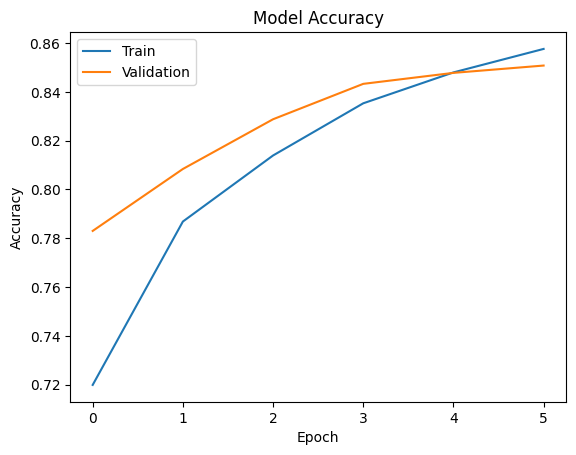

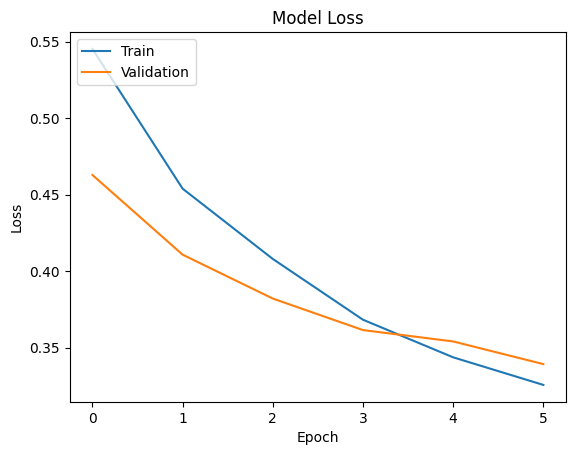

In [ ]:
import matplotlib.pyplot as plt


# Afficher l'accuracy
plt.plot(history_3.history['accuracy'])  # Utiliser 'accuracy' au lieu de 'acc'
plt.plot(history_3.history['val_accuracy'])  # Utiliser 'val_accuracy' au lieu de 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Afficher la loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


The accuracy on the training set is around 86% while on the validation set is around 84% =>Using LSTM architecture the model is performing well on the trainset because the gap is smaller

# Testing Different Word Embedding Methods

In [ ]:
#@title Test the models
text="The movie was fantastic! The plot was engaging, the characters were well-developed, and the acting was superb. I couldn't take my eyes off the screen throughout the entire film."
new_text=preprocess_text(text)

new_text_tokens = tokenizer.texts_to_sequences([new_text])
new_text_padded = pad_sequences(new_text_tokens, maxlen=maxlen, padding='post')

# Make predictions using the trained model
predictions = model_1.predict(new_text_padded)

# Convert predictions to labels (binary in this case)
predicted_labels = (predictions > 0.5).astype(int)

# Print the predicted label (1 for positive, 0 for negative)
print('model _1',predicted_labels)

predictions = model_2.predict(new_text_padded)

# Convert predictions to labels (binary in this case)
predicted_labels = (predictions > 0.5).astype(int)

# Print the predicted label (1 for positive, 0 for negative)
print('model _1',predicted_labels)

predictions = model_3.predict(new_text_padded)

# Convert predictions to labels (binary in this case)
predicted_labels = (predictions > 0.5).astype(int)

# Print the predicted label (1 for positive, 0 for negative)
print('model _3',predicted_labels)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
model _1 [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
model _1 [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
model _3 [[1]]


# Comparison between models

#1-Glove

##GRU

In [ ]:
from keras.layers import Embedding, LSTM, Dense, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D

# Define GRU Model
model_gru_glove = Sequential()
model_gru_glove.add(Embedding(vocab_size, 100,weights=[embedding_matrix], trainable=False))
model_gru_glove.add(GRU(128))
model_gru_glove.add(Dense(1, activation='sigmoid'))
model_gru_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history_gru_glove = model_gru_glove.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)


Epoch 1/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - acc: 0.6743 - loss: 0.5830 - val_acc: 0.8188 - val_loss: 0.4033
Epoch 2/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.8164 - loss: 0.3997 - val_acc: 0.8432 - val_loss: 0.3503
Epoch 3/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8384 - loss: 0.3594 - val_acc: 0.8367 - val_loss: 0.3568
Epoch 4/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8525 - loss: 0.3366 - val_acc: 0.8480 - val_loss: 0.3375
Epoch 5/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.8594 - loss: 0.3200 - val_acc: 0.8568 - val_loss: 0.3283
Epoch 6/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.8724 - loss: 0.2958 - val_acc: 0.8455 - val_loss: 0.3465


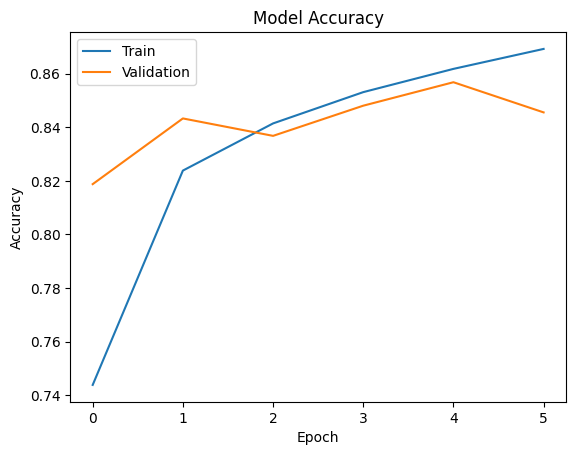

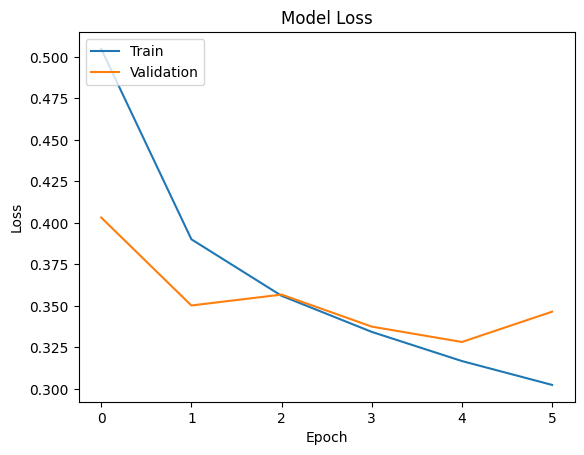

In [ ]:
import matplotlib.pyplot as plt


# Afficher l'accuracy
plt.plot(history_gru_glove.history['acc'])  # Utiliser 'accuracy' au lieu de 'acc'
plt.plot(history_gru_glove.history['val_acc'])  # Utiliser 'val_accuracy' au lieu de 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Afficher la loss
plt.plot(history_gru_glove.history['loss'])
plt.plot(history_gru_glove.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
score_gru_glove= model_gru_glove.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score_gru_glove[0])
print("Test Accuracy:", score_gru_glove[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.8466 - loss: 0.3501
Test Score: 0.3487471342086792
Test Accuracy: 0.8461999893188477


CNN +Rnn Glove

In [ ]:
from keras.layers import Embedding, LSTM, Dense, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D
from keras.initializers import Constant
model_rnn_cnn_glove = Sequential()
model_rnn_cnn_glove.add(Embedding(len(tokenizer.word_index) + 1, 100, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model_rnn_cnn_glove.add(SimpleRNN(64, return_sequences=True))
model_rnn_cnn_glove.add(Conv1D(64, 3, activation='relu'))
model_rnn_cnn_glove.add(GlobalMaxPooling1D())
# model_rnn_cnn_word2vec.add(Flatten())
model_rnn_cnn_glove.add(Dense(units=1, activation='sigmoid'))
model_rnn_cnn_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_rnn_cnn_glove.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_rnn_cnn_glove = model_rnn_cnn_glove.fit(X_train, y_train, batch_size=64, epochs=6, validation_split=0.1)

Epoch 1/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - acc: 0.6743 - loss: 0.5835 - val_acc: 0.8117 - val_loss: 0.4057
Epoch 2/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - acc: 0.8250 - loss: 0.3910 - val_acc: 0.8278 - val_loss: 0.3717
Epoch 3/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - acc: 0.8452 - loss: 0.3537 - val_acc: 0.8405 - val_loss: 0.3518
Epoch 4/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - acc: 0.8560 - loss: 0.3254 - val_acc: 0.8422 - val_loss: 0.3522
Epoch 5/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - acc: 0.8726 - loss: 0.2987 - val_acc: 0.8430 - val_loss: 0.3463
Epoch 6/6
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.8820 - loss: 0.2798 - val_acc: 0.8367 - val_loss: 0.3588


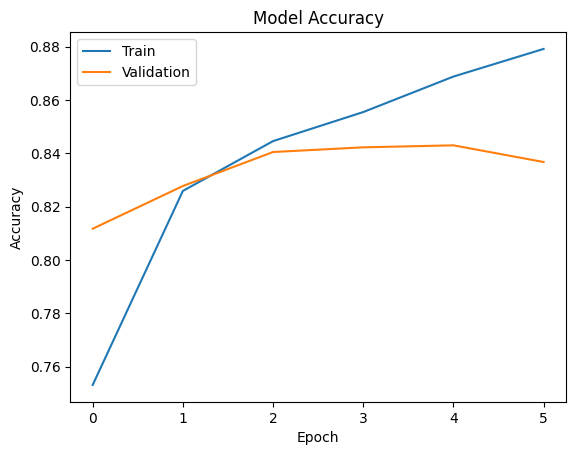

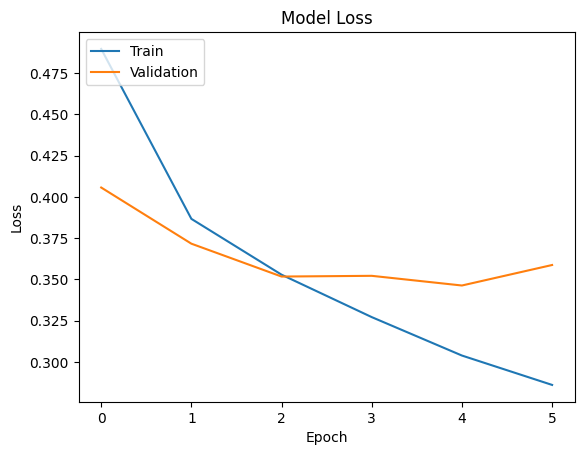

In [ ]:
import matplotlib.pyplot as plt


# Afficher l'accuracy
plt.plot(history_rnn_cnn_glove.history['acc'])  # Utiliser 'accuracy' au lieu de 'acc'
plt.plot(history_rnn_cnn_glove.history['val_acc'])  # Utiliser 'val_accuracy' au lieu de 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Afficher la loss
plt.plot(history_rnn_cnn_glove.history['loss'])
plt.plot(history_rnn_cnn_glove.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
score = model_rnn_cnn_glove.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8320 - loss: 0.3661
Test Score: 0.36711835861206055
Test Accuracy: 0.8335999846458435


# Word2Vec

In [ ]:
import gensim.downloader as api

# Load the pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')



In [ ]:

from gensim.models import KeyedVectors  # For Word2Vec or FastText loading
#embeddings_dict = word2vec_model.wv
print(word2vec_model)

embedding_w2v_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
  if word in word2vec_model.key_to_index:
    embedding_vector = word2vec_model[word]
  if embedding_vector is not None:
    embedding_w2v_matrix[index] = embedding_vector

KeyedVectors<vector_size=300, 3000000 keys>


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Obtention des embeddings Word2Vec pour chaque mot dans le vocabulaire
word_vectors = word2vec_model.wv

# Création de la matrice d'embedding à partir des embeddings Word2Vec
embedding_matrix_word2vec = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix_word2vec[i] = word_vectors[word]

KeyboardInterrupt: 

## LSTM

In [ ]:
# Création du modèle séquentiel
model_lstm_word2vec_custom = Sequential()

# Ajout de la couche d'Embedding avec Word2Vec
model_lstm_word2vec_custom.add(Embedding(vocab_size, 300, weights=[ embedding_w2v_matrix], input_length=maxlen))

# Ajout de la couche LSTM
model_lstm_word2vec_custom.add(LSTM(units=128))

# Ajout de la couche Dense pour la classification binaire
model_lstm_word2vec_custom.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compilation du modèle
model_lstm_word2vec_custom.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entraînement du modèle
history_lstm_word2vec_custom = model_lstm_word2vec_custom.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


In [ ]:
# Évaluation du modèle sur les données de test
score_lstm_word2vec_custom = model_lstm_word2vec_custom.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score_lstm_word2vec_custom[0])
print("Test Accuracy:", score_lstm_word2vec_custom[1])

313/313 [==============================] - 15s 47ms/step - loss: 0.4278 - acc: 0.8468
Test Score: 0.42782071232795715
Test Accuracy: 0.8468000292778015


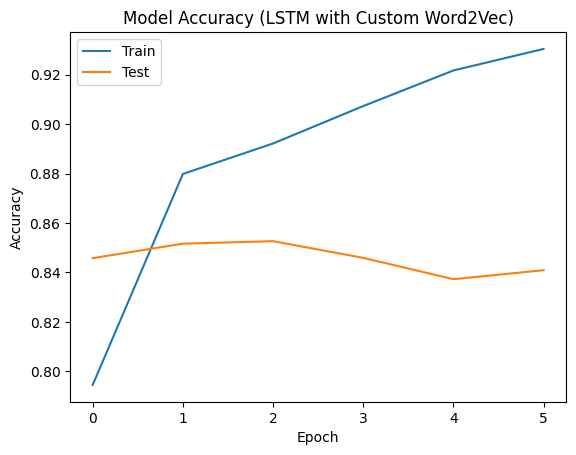

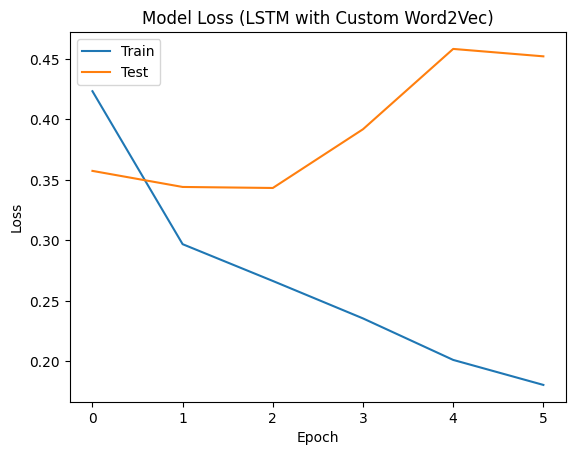

In [ ]:
import matplotlib.pyplot as plt

# Tracé de la courbe d'accuracy
plt.plot(history_lstm_word2vec_custom.history['acc'])
plt.plot(history_lstm_word2vec_custom.history['val_acc'])
plt.title('Model Accuracy (LSTM with Custom Word2Vec)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Tracé de la courbe de loss
plt.plot(history_lstm_word2vec_custom.history['loss'])
plt.plot(history_lstm_word2vec_custom.history['val_loss'])
plt.title('Model Loss (LSTM with Custom Word2Vec)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
def plot_results(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

##Gru

In [ ]:
from keras.layers import Embedding, LSTM, Dense, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D

# Define GRU Model
model_gru_word2vec = Sequential()
model_gru_word2vec.add(Embedding(vocab_size, 300, weights=[ embedding_w2v_matrix], input_length=maxlen, trainable=False))
model_gru_word2vec.add(GRU(128))
model_gru_word2vec.add(Dense(1, activation='sigmoid'))
model_gru_word2vec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history_gru_word2vec = model_gru_word2vec.fit(X_train, y_train, batch_size=64, epochs=6, validation_split=0.1)


Epoch 1/6
563/563 [==============================] - 135s 234ms/step - loss: 0.4756 - accuracy: 0.7631 - val_loss: 0.3671 - val_accuracy: 0.8363
Epoch 2/6
563/563 [==============================] - 127s 225ms/step - loss: 0.3418 - accuracy: 0.8504 - val_loss: 0.3251 - val_accuracy: 0.8533
Epoch 3/6
563/563 [==============================] - 130s 232ms/step - loss: 0.3161 - accuracy: 0.8648 - val_loss: 0.3120 - val_accuracy: 0.8670
Epoch 4/6
563/563 [==============================] - 131s 233ms/step - loss: 0.2989 - accuracy: 0.8719 - val_loss: 0.3210 - val_accuracy: 0.8610
Epoch 5/6
563/563 [==============================] - 124s 221ms/step - loss: 0.2793 - accuracy: 0.8814 - val_loss: 0.3435 - val_accuracy: 0.8508
Epoch 6/6
563/563 [==============================] - 126s 224ms/step - loss: 0.2589 - accuracy: 0.8921 - val_loss: 0.2920 - val_accuracy: 0.8715


In [ ]:
score = model_gru_word2vec.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 20s 65ms/step - loss: 0.2905 - accuracy: 0.8732
Test Score: 0.29051777720451355
Test Accuracy: 0.873199999332428


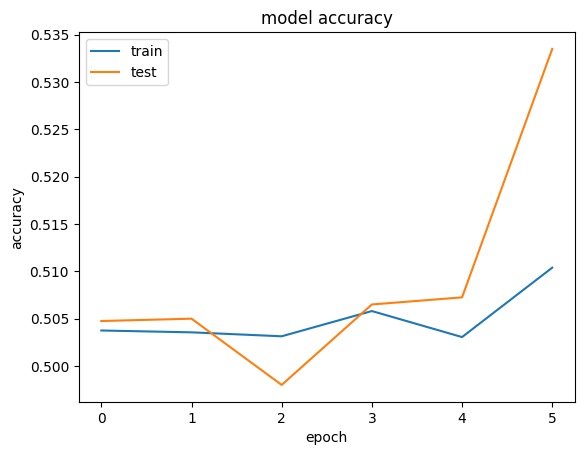

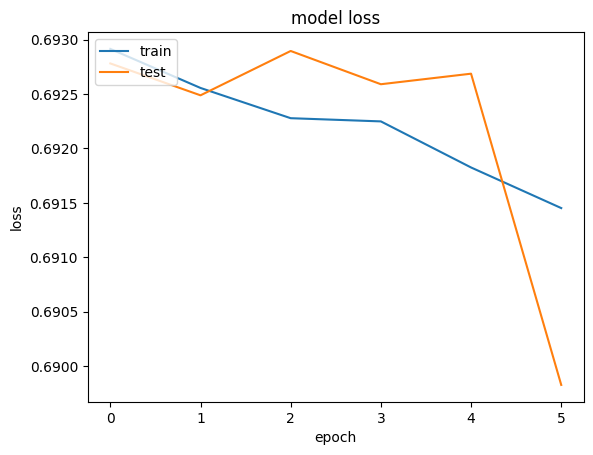

In [ ]:
plot_results(history_gru_word2vec)

## RNN + CNN


In [ ]:
from keras.layers import Embedding, LSTM, Dense, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D

model_rnn_cnn_word2vec = Sequential()
model_rnn_cnn_word2vec.add(Embedding(len(tokenizer.word_index) + 1, 300,  weights=[embedding_w2v_matrix], input_length=maxlen, trainable=False))
model_rnn_cnn_word2vec.add(SimpleRNN(64, return_sequences=True))
model_rnn_cnn_word2vec.add(Conv1D(64, 3, activation='relu'))
model_rnn_cnn_word2vec.add(GlobalMaxPooling1D())
# model_rnn_cnn_word2vec.add(Flatten())
model_rnn_cnn_word2vec.add(Dense(units=1, activation='sigmoid'))
model_rnn_cnn_word2vec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn_cnn_word2vec.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          27764100  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            12352     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 27799877 (106.05 MB)
Trainable params: 35777 (139.75 KB)
Non-trainable params: 27764100 (105.91 MB)
______

In [ ]:
history_cnn_rnn_word2vec = model_rnn_cnn_word2vec.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.1)


Epoch 1/5
282/282 [==============================] - 21s 71ms/step - loss: 0.6950 - accuracy: 0.5107 - val_loss: 0.6960 - val_accuracy: 0.4955
Epoch 2/5
282/282 [==============================] - 20s 70ms/step - loss: 0.6929 - accuracy: 0.5115 - val_loss: 0.6885 - val_accuracy: 0.5293
Epoch 3/5
282/282 [==============================] - 19s 66ms/step - loss: 0.6921 - accuracy: 0.5171 - val_loss: 0.6922 - val_accuracy: 0.5102
Epoch 4/5
282/282 [==============================] - 20s 71ms/step - loss: 0.6919 - accuracy: 0.5149 - val_loss: 0.6890 - val_accuracy: 0.5282
Epoch 5/5
282/282 [==============================] - 19s 66ms/step - loss: 0.6907 - accuracy: 0.5143 - val_loss: 0.6934 - val_accuracy: 0.5123


In [ ]:
score = model_rnn_cnn_word2vec.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 5s 15ms/step - loss: 0.8930 - accuracy: 0.4961
Test Score: 0.8930007815361023
Test Accuracy: 0.4961000084877014


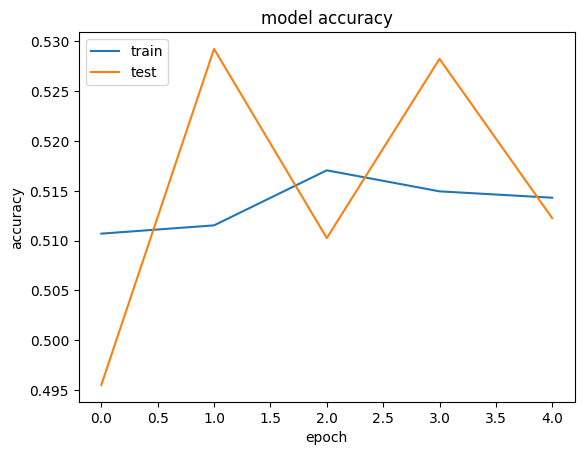

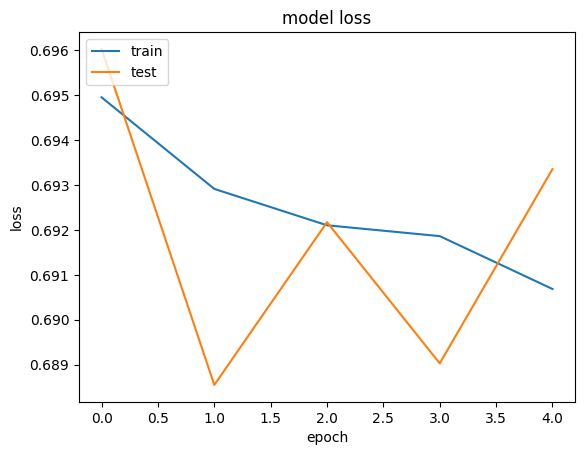

In [ ]:
plot_results(history_cnn_rnn_word2vec)


#generate embeddings
* TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how **important** a word is to a document in a collection or corpus


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, GRU, Conv1D, MaxPooling1D, Dense
from sklearn.feature_extraction.text import TfidfVectorizer  # for TF-IDF
from gensim.models import FastText
from numpy import array
from numpy import asarray
from numpy import zeros
from sklearn.feature_extraction.text import TfidfVectorizer

MAX_FEATURES= vocab_size
EMBEDDING_DIM=100
def get_embeddings(embeddings_method):
  if embeddings_method == "glove":
    embeddings_dictionary = dict()
    glove_file = open("/tmp/glove/glove.6B.100d.txt", encoding="utf8")
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:],dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
    glove_file.close()
    embedding_matrix = zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
      embedding_vector = embeddings_dictionary.get(word)
      if embedding_vector is not None:
          embedding_matrix[index] = embedding_vector

  elif embeddings_method == "word2vec":
      embeddings_index = {}
      f = open('/content/imdb_embedding_word2vec.txt')
      for line in f:
          # print(line)
          values = line.split()
          word = values[0] # Since the word is at the 0th index
          coefs = np.asarray(values[1:]) # From the 1st position onwards the values are the embedding values
          embeddings_index[word] = coefs
      f.close()
      embedding_matrix = np.zeros((vocab_size, 100))
      for word, i in tokenizer.word_index.items():
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
              embedding_matrix[i] = embedding_vector

  elif embeddings_method == "fasttext":
      embedding_matrix = np.zeros((MAX_FEATURES,300))
      for word, index in tokenizer.word_index.items():
        if index > MAX_FEATURES:
            continue  # Skip words beyond MAX_FEATURES
        try:
            embedding_vector = fasttext[word]
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
        except KeyError:
            embedding_matrix[index] =np.zeros(300)
  else:
    raise ValueError("Invalid embedding method")

  return embedding_matrix


#fasttext

In [ ]:
#@title Load Fasttext word embedding model
import gensim.downloader as api

fasttext = api.load("fasttext-wiki-news-subwords-300")


[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
embedding_matrix = np.zeros((MAX_FEATURES,300))
for word, index in tokenizer.word_index.items():
        if index > MAX_FEATURES:
            continue  # Skip words beyond MAX_FEATURES
        try:
            embedding_vector = fasttext[word]
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
        except KeyError:
            embedding_matrix[index] =np.zeros(300)

In [ ]:
def create_model(embeddings_method, model_type, embedding_matrix):
    units = 128
    filters = 128
    kernel_size = 5
    MAX_FEATURES=vocab_size
    EMBEDDING_DIM =100
    model = Sequential()
    model.add(Embedding(vocab_size,embedding_matrix.shape[1], weights=[embedding_matrix],input_length=maxlen , trainable=False))
    if model_type == "LSTM":
        model.add(LSTM(units=128))
    elif model_type == "Conv1D":
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D())
        model.add(Flatten())
    elif  model_type == "simple":
       model.add(Flatten())
    else:
        raise ValueError("Invalid model type")

    # Add output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


# Define combinations of embedding methods and model types
embedding_methods = ["fasttext"]
model_types = ["LSTM","Conv1D",]

# List to store all models
all_models = []

# Iterate over combinations and create models
for model_type in model_types:
     for embedding_method in embedding_methods:
        print("model : ",model_type," **** embedding method : ",embedding_method)
        embedding_matrix = get_embeddings(embedding_method)  # Assuming you have word_index and texts defined
        model = create_model(embedding_method, model_type, embedding_matrix)
        history = model.fit(X_train, y_train, epochs=6, batch_size=128, validation_split=0.2, verbose=1)
        model.summary()
        score = model.evaluate(X_test, y_test, verbose=1)
        print("Test Score:", score[0])
        print("Test Accuracy:", score[1])



model :  simple  **** embedding method :  fasttext


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6308 - loss: 0.6468 - val_accuracy: 0.7476 - val_loss: 0.5565
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7897 - loss: 0.5113 - val_accuracy: 0.7523 - val_loss: 0.5218
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8214 - loss: 0.4531 - val_accuracy: 0.7797 - val_loss: 0.4856
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.4105 - val_accuracy: 0.7776 - val_loss: 0.4754
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8507 - loss: 0.3885 - val_accuracy: 0.7781 - val_loss: 0.4694
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8611 - loss: 0.3642 - val_accuracy: 0.7841 - val_loss: 0.4634


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (128, 100, 300)             │      27,764,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (128, 30000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (128, 1)                    │          30,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,854,105 (106.25 MB)

 Trainable params: 30,001 (117.19 KB)

 Non-trainable params: 27,764,100 (105.91 MB)

 Optimizer params: 60,004 (234.39 KB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7818 - loss: 0.4680
Test Score: 0.46479371190071106
Test Accuracy: 0.7838000059127808
model :  LSTM  **** embedding method :  fasttext
Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6511 - loss: 0.6072 - val_accuracy: 0.8110 - val_loss: 0.4118
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8029 - loss: 0.4374 - val_accuracy: 0.8209 - val_loss: 0.3989
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8083 - loss: 0.4234 - val_accuracy: 0.8167 - val_loss: 0.3973
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8210 - loss: 0.3922 - val_accuracy: 0.8205 - val_loss: 0.3967
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8242 - loss: 0.3912 - val_accuracy: 0.8425 - val_loss: 0.3571
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8433 - loss: 0.3561 - val_accuracy: 0.8381 - val_loss: 0.3724


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (128, 100, 300)             │      27,764,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (128, 128)                  │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (128, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,423,433 (108.43 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 27,764,100 (105.91 MB)

 Optimizer params: 439,556 (1.68 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8319 - loss: 0.3767
Test Score: 0.37560075521469116
Test Accuracy: 0.833899974822998
model :  Conv1D  **** embedding method :  fasttext
Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6453 - loss: 0.6082 - val_accuracy: 0.7665 - val_loss: 0.4766
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8128 - loss: 0.4113 - val_accuracy: 0.8309 - val_loss: 0.3847
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8439 - loss: 0.3535 - val_accuracy: 0.8434 - val_loss: 0.3599
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8675 - loss: 0.3126 - val_accuracy: 0.8431 - val_loss: 0.3626
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8951 - loss: 0.2660 - val_accuracy: 0.8334 - val_loss: 0.3868
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9196 - loss: 0.2223 - val_accuracy: 0.8382 - val_loss: 0.3738


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (128, 100, 300)             │      27,764,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (128, 96, 128)              │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (128, 48, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (128, 6144)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (128, 1)                    │           6,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,358,921 (108.18 MB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 27,764,100 (105.91 MB)

 Optimizer params: 396,548 (1.51 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8319 - loss: 0.3851
Test Score: 0.37457022070884705
Test Accuracy: 0.8352000117301941


GRU

In [ ]:
embedding_matrix = get_embeddings("fasttext")  # Assuming you have word_index and texts defined
model_gru = Sequential()
model_gru.add(Embedding(vocab_size, 300, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model_gru.add(GRU(128))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_gru.fit(X_train, y_train, epochs=6, batch_size=128, validation_split=0.2, verbose=1)
model_gru.summary()
score =model_gru.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.6368 - loss: 0.6406 - val_accuracy: 0.8213 - val_loss: 0.4046
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8259 - loss: 0.3908 - val_accuracy: 0.8304 - val_loss: 0.3833
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8534 - loss: 0.3384 - val_accuracy: 0.8640 - val_loss: 0.3135
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8681 - loss: 0.3104 - val_accuracy: 0.8786 - val_loss: 0.2865
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8750 - loss: 0.3048 - val_accuracy: 0.8806 - val_loss: 0.2823
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8843 - loss: 0.2850 - val_accuracy: 0.8800 - val_loss: 0.2818


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (128, 300, 300)             │      27,764,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (128, 128)                  │         165,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (128, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,259,849 (107.80 MB)

 Trainable params: 165,249 (645.50 KB)

 Non-trainable params: 27,764,100 (105.91 MB)

 Optimizer params: 330,500 (1.26 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8765 - loss: 0.2882
Test Score: 0.28590333461761475
Test Accuracy: 0.8792999982833862


#tfidf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(X)
tfidf_matrix = tfidf_matrix.toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

###LSTM

In [ ]:
from keras.layers import Reshape
from keras.callbacks import EarlyStopping

model_lstm_tfidf = Sequential()
model_lstm_tfidf.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_lstm_tfidf.add(Reshape((64, 1)))
model_lstm_tfidf.add(LSTM(128,input_shape=(X_train.shape[1],)))
model_lstm_tfidf.add(Dense(1, activation='sigmoid'))
model_lstm_tfidf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history_lstm_tfidf = model_lstm_tfidf.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping], validation_data=(X_test, y_test))

Epoch 1/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7129 - loss: 0.5230 - val_accuracy: 0.8706 - val_loss: 0.3029
Epoch 2/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8713 - loss: 0.3038 - val_accuracy: 0.8702 - val_loss: 0.3017
Epoch 3/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8765 - loss: 0.2911 - val_accuracy: 0.8661 - val_loss: 0.3053
Epoch 4/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8791 - loss: 0.2829 - val_accuracy: 0.8738 - val_loss: 0.2974
Epoch 5/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8907 - loss: 0.2623 - val_accuracy: 0.8718 - val_loss: 0.3009
Epoch 6/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9034 - loss: 0.2374 - val_accuracy: 0.8658 - val_loss: 0.3254


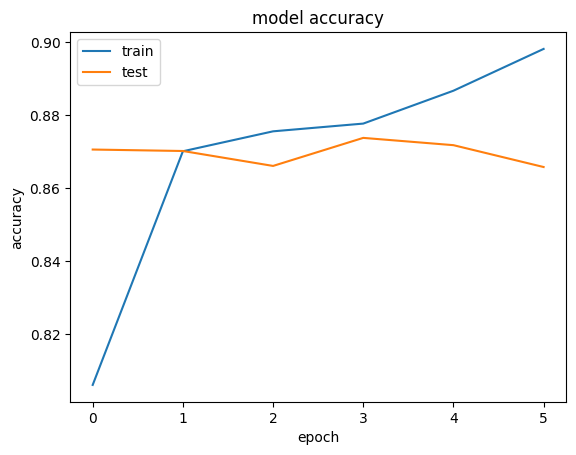

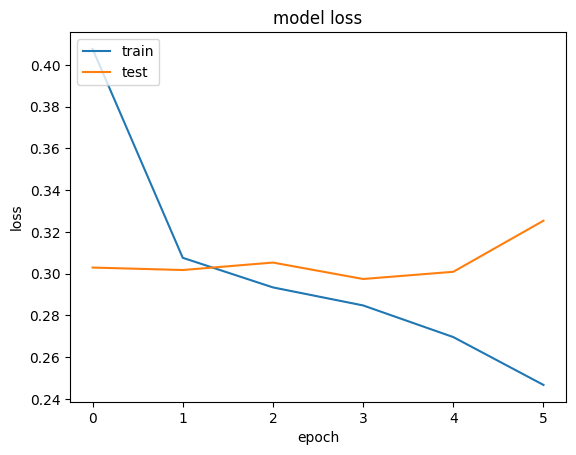

In [ ]:
plot_results(history_lstm_tfidf)

In [ ]:
score = model_lstm_tfidf.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8740 - loss: 0.2978
Test Score: 0.29743555188179016
Test Accuracy: 0.8737999796867371


CNN+ RNN

In [ ]:
from keras.regularizers import l2

model_cnn_rnn_tfidf = Sequential()
model_cnn_rnn_tfidf.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
model_cnn_rnn_tfidf.add(Reshape((64, 1)))
model_cnn_rnn_tfidf.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn_rnn_tfidf.add(MaxPooling1D())
model_cnn_rnn_tfidf.add(SimpleRNN(units=128))
model_cnn_rnn_tfidf.add(Flatten())
model_cnn_rnn_tfidf.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model_cnn_rnn_tfidf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
history_cnn_rnn_tfidf = model_cnn_rnn_tfidf.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping], validation_data=(X_test, y_test))

Epoch 1/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.7631 - loss: 0.8541 - val_accuracy: 0.8584 - val_loss: 0.4178
Epoch 2/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8588 - loss: 0.4070 - val_accuracy: 0.8655 - val_loss: 0.3712
Epoch 3/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8665 - loss: 0.3692 - val_accuracy: 0.8627 - val_loss: 0.3638
Epoch 4/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8686 - loss: 0.3561 - val_accuracy: 0.8628 - val_loss: 0.3672
Epoch 5/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8702 - loss: 0.3562 - val_accuracy: 0.8641 - val_loss: 0.3622
Epoch 6/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8735 - loss: 0.3486 - val_accuracy: 0.8643 - val_loss: 0.3667


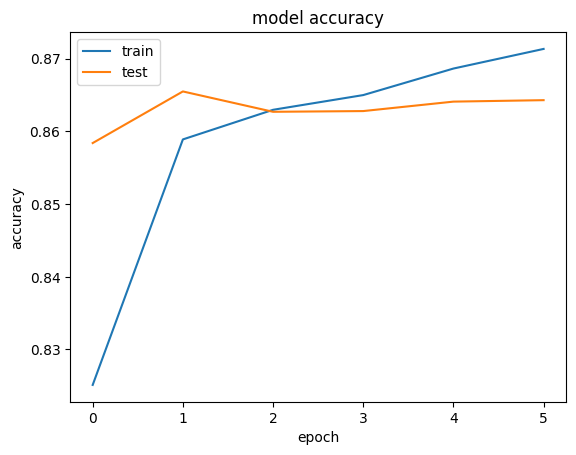

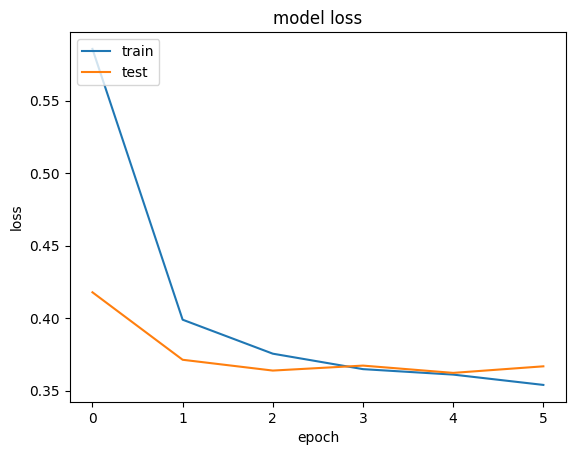

In [ ]:
plot_results(history_cnn_rnn_tfidf)

In [ ]:
score = model_cnn_rnn_tfidf.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8642 - loss: 0.3652
Test Score: 0.3621636927127838
Test Accuracy: 0.8640999794006348


###GRU

In [ ]:
model_gru_tfidf = Sequential()
model_gru_tfidf.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_gru_tfidf.add(Reshape((64, 1)))
model_gru_tfidf.add(GRU(units=128))
model_gru_tfidf.add(Flatten())
model_gru_tfidf.add(Dense(units=1, activation='sigmoid'))

model_gru_tfidf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
history_gru_tfidf = model_gru_tfidf.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping],  validation_data=(X_test, y_test))

Epoch 1/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6756 - loss: 0.5800 - val_accuracy: 0.8644 - val_loss: 0.3129
Epoch 2/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8682 - loss: 0.3121 - val_accuracy: 0.8701 - val_loss: 0.3014
Epoch 3/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8051 - loss: 0.4082 - val_accuracy: 0.8670 - val_loss: 0.3134
Epoch 4/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8705 - loss: 0.3028 - val_accuracy: 0.8689 - val_loss: 0.3027
Epoch 5/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8754 - loss: 0.2900 - val_accuracy: 0.8711 - val_loss: 0.3010
Epoch 6/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8820 - loss: 0.2760 - val_accuracy: 0.8684 - val_loss: 0.3042


In [ ]:
plot_results(history_gru_tfidf)

In [ ]:
score = model_gru_tfidf.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8678 - loss: 0.3019
Test Score: 0.301040381193161
Test Accuracy: 0.8711000084877014


#Statics



|   | Glove | Wor2vec | Fasttext |Tf-idf |
|---|-------|      ---|-       --|   --    |
| LSTM | 0.84| 0.84 | 0.83389   |0.873      |
| GRU | 0.848| 0.87 | 0.87     |0.8711|
| RNN + CNN  | 0.83| 0.83| 0.83|0.864   |